# Week 7B: Sensitivity Analysis

<font color='blue'><b>Goals of this notebook:</b></font> Analyse sensitivity of an optimal solution of an LP with respect to changing the parameters of the right hand side and the objective.

## Motivation

Consider the following modified version of the coal factory example:

$$
\begin{equation}
    \begin{array}{lrrrrrrl}
        \text{max}  & &          22x_1 &+&          20x_2    &       &   \\
        \text{s.t.}   
                    & & \frac{1}{2}x_1 &+&            x_2    & \leq  &10 \\
                    & &            x_1 &+&            x_2    & \leq  &20 \\
                    & &\frac{1}{12}x_1 &+&\frac{1}{24}x_2    & \leq  & 1 \\
                    &-&          12x_1 &+&           8x_2    & \leq  & 0 \\
                    & &            x_1 & &                   & \geq  & 0 \\
                    & &                & &            x_2    & \geq  & 0 
    \end{array}
\end{equation}$$

We can visualize the feasible regions of this LP:

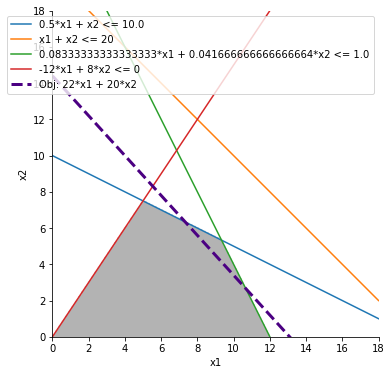

In [1]:
# Import packages
%matplotlib inline
import numpy as np
import pulp
from plotLP import *  

# Create the LP
mylp = pulp.LpProblem("MyLP", pulp.LpMaximize)

# Create the variables
x1 = pulp.LpVariable('x1', lowBound=0, cat=pulp.LpContinuous)
x2 = pulp.LpVariable('x2', lowBound=0, cat=pulp.LpContinuous)

# Add the objective function
mylp +=   22*x1 +   20*x2

# Add the constraints
mylp +=  1/2*x1 +      x2 <= 10
mylp +=      x1 +      x2 <= 20
mylp += 1/12*x1 + 1/24*x2 <= 1
mylp +=  -12*x1 +    8*x2 <= 0

plotLP(mylp, x_lower=0, x_upper=18, y_lower=0, y_upper=18)

We can read from the graph that the optimal point lies at the intersection of the lines $\frac{1}{2}x_1+x_2=10$ and $\frac{1}{12}x_1+\frac{1}{24}x_2=1$, with the coordinates $(x_1,x_2)=(\frac{28}{3},\frac{16}{3}) \approx (9.3,5.3)$. This can be verified using PuLP:

In [2]:
mylp.solve()
print(f"The optimal solution is ({x1.value():.1f},{x2.value():.1f}) " +
      f"with an objective value {mylp.objective.value():.1f}.")

The optimal solution is (9.3,5.3) with an objective value 312.0.


Note that the optimal solution satisfies the first and the third constraint with equality and all other constraints with strict inequality. When an optimal solution satisfies a constraint with an equality, it means that the corresponding slack variable is $0$, and we call that the constraint is *tight* in this optimal solution.

If we change the RHS of the first constraint to $8$, the value of the optimal point will change, but it will still lie at the intersection of the lines $\frac{1}{2}x_1+x_2=10$ and $\frac{1}{12}x_1+\frac{1}{24}x_2=1$. In other words, the first and the third constraints are still tight when $b_1=8$. 

The optimal solution is (10.7,2.7) with an objective value 288.0.


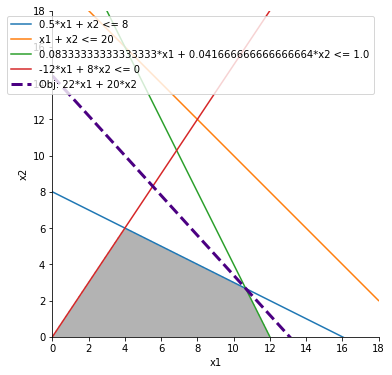

In [3]:
mylp.constraints['_C1'].changeRHS(8)
mylp.solve()
print(f"The optimal solution is ({x1.value():.1f},{x2.value():.1f}) " +
      f"with an objective value {mylp.objective.value():.1f}.")
plotLP(mylp, x_lower=0, x_upper=18, y_lower=0, y_upper=18)

However, if we change the RHS of the first constraint to $4$, the optimal point will no longer lie at the intersection of the lines $\frac{1}{2}x_1+x_2=10$ and $\frac{1}{12}x_1+\frac{1}{24}x_2=1$. It will be at the intersection of the line $\frac{1}{12}x_1+\frac{1}{24}x_2=1$ and the $x_1$ axis. The third constraint is no longer tight when $b_1=4$. 

The optimal solution is (8.0,0.0) with an objective value 176.0.


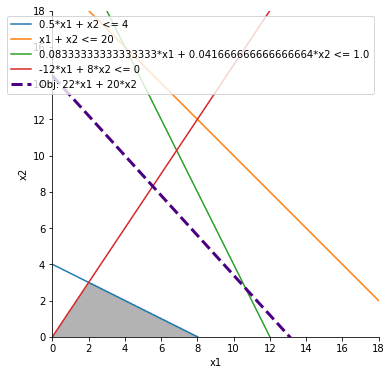

In [4]:
mylp.constraints['_C1'].changeRHS(4)
mylp.solve()
print(f"The optimal solution is ({x1.value():.1f},{x2.value():.1f}) " +
      f"with an objective value {mylp.objective.value():.1f}.")
plotLP(mylp, x_lower=0, x_upper=18, y_lower=0, y_upper=18)

We have learned that each vertex of the feasible region corresponds to a tableau. When $b_1=10$ and $b_1=8$, the optimal tableaus have the same basis. When $b_1=4$, the optimal tableau has a different basis from when $b_1=10$ and $b_1=8$. In this notebook, we are interested in how much we can vary each $b_i$ without changing the optimal basis for the original LP. This is known as the *sensitivity range* of $b_i$.

## Task 1: Performing sensitivity analysis manually

Solving the LP with the Simplex Method yields the optimal long tableau

$$\begin{equation}
\begin{array}{l|rrrrrr|r}
    & y_1          & y_2 & y_3 & y_4 & x_1 & x_2 & 1            \\ \hline
  z & 12           & 0   & 192 & 0   & 0   & 0   & 312          \\ \hline
    & -\frac{2}{3} & 0   & 16  & 0   & 1   & 0   & \frac{28}{3} \\
    & -\frac{2}{3} & 1   & -8  & 0   & 0   & 0   & \frac{16}{3} \\
    & \frac{4}{3}  & 0   & -8  & 0   & 0   & 1   & \frac{16}{3} \\
    & -\frac{56}{3}& 0   & 256 & 1   & 0   & 0   & \frac{208}{3}
\end{array}
\end{equation}$$

### Task 1.1: Determing the sensitivity range of $b_i$

As mentioned above, we would like to know how much we can vary each $b_i$ without changing the optimal basis for the original LP. In this problem, $b_1=10$ in the original LP, and the optimal basis is $\{y_2, y_4, x_1, x_2\}$. We have already seen that if $b_1=8$, the optimal basis would not change; if $b_1=4$, the optimal basis would be different. But what is the exact range of $b_1$? Such a question can be answered using the procedures described in section 3.8 of the lecture notes.

As an example, we will find out the sensitivity range of $b_1$ following the steps on pages 62–64 of the lecture notes.

Recall that increasing  $b_i$ by one unit can be compensated in the tableau by decreasing the corresponding slack variable $y_i$ by one unit. For example, increasing $y_i$ by 2 is equivalent to decreasing $b_i$ by 2 in a tableau. Therefore, the sensitivity range of $b_1$ can be determined by finding a range of $y_1$ where the variables in the optimal basis stay feasible.

From the optimal tableau above, we can represent the variables in optimal basis ${y_2, y_4, x_1, x_2}$ in terms of $y_1$ and $y_3$. In the sensitivity analysis, we change only one variable at a time, so $y_3$ will stay $0$ in the equation below, and only $y_1$ remains.

$$\begin{equation}
    \left(
        \begin{array}{c}
             x_1 \\
             y_2 \\
             x_2 \\
             y_4 
         \end{array}
    \right)
    =
    \left(
        \begin{array}{c}
            \frac{28}{3}\\
            \frac{16}{3}\\
            \frac{16}{3}\\
            \frac{208}{3}
        \end{array}
    \right)
    - y_1 \left(
        \begin{array}{c}
             -\frac{2}{3}\\
             -\frac{2}{3}\\
             \frac{4}{3}\\
             -\frac{56}{3}
        \end{array}
    \right)
\end{equation}$$

The basic solution must remain feasible, i. e. $x_1, y_2, x_2, y_4 \geq 0$. Therefore, $y_1$ should stay within the interval $[\left(\frac{208}{3} \middle/ -\frac{56}{3}\right),\left(\frac{16}{3} \middle/ \frac{4}{3}\right)] = [-\frac{26}{7},4]$.

Hence, we can vary $b_1$ within $[10-4,10+\frac{26}{7}] \approx [6,13.71]$ without changing the optimal basis.

**Your task**: Find the sensitivity range of $b_3$ using the same procedure described above.

*Your answer here.* <br> <br> <br>

### Task 1.2: Determing the sensitivity range of $c_i$

Similar to task 1.1, we would like to know how much we can change each coefficient $c_i$ of the objective without changing the structure of the optimal solution. In other words, we are interested in the *sensitivity range* of each $c_i$. To do so, we refer to the optimal tableau of the dual problem, and follow the same procedures as in task 1.1.


$$\begin{equation}
\begin{array}{l|rrrrrr|r}
    & y_1 & y_2          & y_3 & y_4           & x_1          & x_2 & 1            \\ \hline
  z & 0   &\frac{16}{3} & 0   &\frac{208}{3} &\frac{28}{3}  &\frac{16}{3}   & 312  \\ \hline
    & 1 & \frac{2}{3}   & 0  & \frac{56}{3}  &\frac{2}{3}  &-\frac{4}{3}   & 12 \\
    & 0 & 8             & 1  & -256          &-16           & 8            & 192 \\
\end{array}
\end{equation}$$



**Your task**: Find the sensitivity ranges of $c_1$ and $c_2$. You can refer to the steps described on pages 64–66 of the script for more details.

*Your answer here.* <br> <br> <br>

*Remark: The analysis here is applicable to non-degenerate cases only, where the RHS of the constraint rows are non-zero in the tableaus.*

## Task 2: Performing numerical sensitivity analysis

In this task, our goal is to perform the sensitivity analysis numerically.

### Task 2.1: Writing a function to find tight constraints

To see if the structure of the optimal solution has changed or remained the same after we changed one of the coefficients, we need to be able to find all tight constraints with respect to the new optimal solution. Let's write a function for this step since it will be repeated many times.

**Your task**: Implement a function that takes the above solved `LpProblem` 'mylp' as the input and returns the list of indices of constraints that are tight with respect to the optimal solution.

You might find the function `mylp.constraints['_C1'].value()` helpful for finding out whether a constraint is tight.

In [ ]:
# Define the function here

def get_tight_constraints(mylp):
    
    """Find a list of constraints that are tight in the optiminal solution of the given LP.

    Args:
      - mylp: The PuLP LP object we created earlier in this workbook.

    Returns:
      - A list of integers representing the indices of tight constraints.
      
    """
    
    '???'


Test your function on the original instance. We will often refer to the list of tight constraints with respect to the original optimal solution in the future, so you should save the result for later use.

In [ ]:
mylp.constraints['_C1'].changeRHS(10) # recover the constraints of the original LP
mylp.solve()

# Test the function here
tightC = get_tight_constraints(mylp)
print(tightC)  # Expected output: [1, 3]


### Task 2.2: Computing sensitivity ranges

**Your task**: Numerically determine the sensitivity ranges of $b_1$, $b_3$, $c_1$ and $c_2$ for this specific LP. We outline the plan using the lower bound on $b_1$ as an example.

#### Lower bound of the sensitivity range of $b_1$

First, we find a value of $b_1$ that lies below the lower bound of the sensitivity range, i.e., a sufficiently small $b_1$ for which the optimal basis is no longer the same as for the original optimal solution.

In [ ]:
# Find a lower bound here
b1_min = 4
mylp.constraints['_C1'].changeRHS(b1_min)
mylp.solve()
print(get_tight_constraints(mylp)) # Expected output: [1]


Now, starting with the value you found above, increase $b_1$ iteratively until you get to a point that satisfies the same (or more) constraints as the original optimal solution with equality. This is the lower end of the sensitivity range. We recommend to use an increment of `0.01`.

Note that the closer your starting value to the lower end of the sensitivity range, the better, as it will take fewer iterations to find the endpoint within the same amount of time.

In [ ]:
# Find the endpoint of the sensitivity range here

'???'


Finally, define a general function to find the boundaries of the sensitivity ranges of $b_3$, $c_1$, and $c_2$. Below, we have provided an example of how this function could look like, but you can start from scratch and write the function in your own style.

In [ ]:
# As we repeatedly use a similar idea, we define a general function to find the boundary

def find_range_endpoint(mylp, coef, ind, start, step) -> float:
    
    """Find the endpoint of the sensitivity range of the specified coefficient
       in the LP defined above.

    Args:
      - mylp:  The PuLP LP object we created earlier in this workbook.
      - coef:  A string taking the value 'b' or 'c' indicating the type of coefficient
               of interest.
      - ind:   An integer representing the index of the coefficient.
      - start: A real number representing the starting point of the iteration.
      - step:  A real number representing the increment for each iteration. If positive,
               then the function will look for the upper bound of the sensitivity range;
               if negative, then the function will look for the lower bound. 

    Returns:
      - val: A number representing the upper or lower bound of the sensitivity range.
      
    """
    
    '???'


If you have used our template, then you can run the code sections below to test your function.

#### Sensitivity range of $b_1$

In [ ]:
b1_min = find_range_endpoint(mylp = mylp, coef = 'b', ind = 1, start =  5, step =  0.01)
b1_max = find_range_endpoint(mylp = mylp, coef = 'b', ind = 1, start = 15, step = -0.01)
print(f"Actual:   The coefficient b1 varies between {b1_min:.2f} and {b1_max:.2f}.")
print("Expected: The coefficient b1 varies between 6.00 and 13.71.")

#### Sensitivity range of $b_3$

In [ ]:
b3_min = find_range_endpoint(mylp = mylp, coef = 'b', ind = 3, start = 0, step =  0.01)
b3_max = find_range_endpoint(mylp = mylp, coef = 'b', ind = 3, start = 5, step = -0.01)
print(f"Actual:   The coefficient b3 varies between {b3_min:.2f} and {b3_max:.2f}.")
print("Expected: The coefficient b3 varies between 0.73 and 1.66.")

#### Sensitivity range of $c_1$

In [ ]:
c1_min = find_range_endpoint(mylp = mylp, coef = 'c', ind = 1, start =  0, step =  0.1)
c1_max = find_range_endpoint(mylp = mylp, coef = 'c', ind = 1, start = 50, step = -0.1)
print(f"Actual:   The coefficient c1 varies between {c1_min:.0f} and {c1_max:.0f}.")
print("Expected: The coefficient c1 varies between 10 and 40.")

#### Sensitivity range of $c_2$

In [ ]:
c2_min = find_range_endpoint(mylp = mylp, coef = 'c', ind = 2, start =  0, step =  0.1)
c2_max = find_range_endpoint(mylp = mylp, coef = 'c', ind = 2, start = 50, step = -0.1)
print(f"Actual:   The coefficient c2 varies between {c2_min:.0f} and {c2_max:.0f}.")
print("Expected: The coefficient c2 varies between 11 and 44.")